In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_new_feature_name_df(old_feature_name_df):
    # cumcount() : 각 아이템들이 몇번째 값인지 나타내주는 함수
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), 
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0] + '_' + str(x[1])
                                                                                               if x[1] > 0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

# 데이터 세트를 불러오는 함수 생성
def get_human_dataset():
    
    # 각 데이터 파일은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당
    feature_name_df = pd.read_csv('./data/UCI_HAR_Dataset/features.txt', sep='\s+',
                                  header=None, names=['column_index', 'column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame 생성
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrmae에 피처명을 칼럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 세트의 테스트 피처 데이터를 DataFrame으로 로딩. 칼럼명은 feature_name 적용
    X_train = pd.read_csv('./data/UCI_HAR_Dataset/train/X_train.txt', sep='\s+', names=feature_name)
    X_test = pd.read_csv('./data/UCI_HAR_Dataset/test/X_test.txt', sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터를 DataFrame으로 로딩하고 칼럼명은 action으로 부여
    y_train = pd.read_csv('./data/UCI_HAR_Dataset/train/y_train.txt', sep='\s+', names=['action'], header=None)
    y_test = pd.read_csv('./data/UCI_HAR_Dataset/test/y_test.txt', sep='\s+', names=['action'], header=None)
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환
    return X_train, X_test, y_train, y_test

In [3]:
# 결정 트리에서 사용한 get_human_dataset()을 이용해 학습/테스트용 DataFrame반환
X_train, X_test, y_train, y_test = get_human_dataset()

In [4]:
from sklearn.model_selection import GridSearchCV
import time

params = {
    'max_depth': [8, 16, 24],
    'min_samples_leaf' : [1, 6, 12],
    'min_samples_split' : [2, 8, 6],
}

start_time = time.time()
# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

print('최적의 하이퍼 파라미터 :\n', grid_cv.best_params_)
print('최고 예측 정확도 : {:.4f}'.format(grid_cv.best_score_))
print('수행 시간 :', time.time()-start_time)

최적의 하이퍼 파라미터 :
 {'max_depth': 16, 'min_samples_leaf': 6, 'min_samples_split': 2}
최고 예측 정확도 : 0.9165
수행 시간 : 113.11469602584839


In [5]:
rf_clf1 = RandomForestClassifier(n_estimators=100, min_samples_leaf=6, max_depth=6, min_samples_split=2, random_state=0)

rf_clf1.fit(X_train, y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도 : {:.4f}'.format(accuracy_score(y_test, pred)))

예측 정확도 : 0.9019


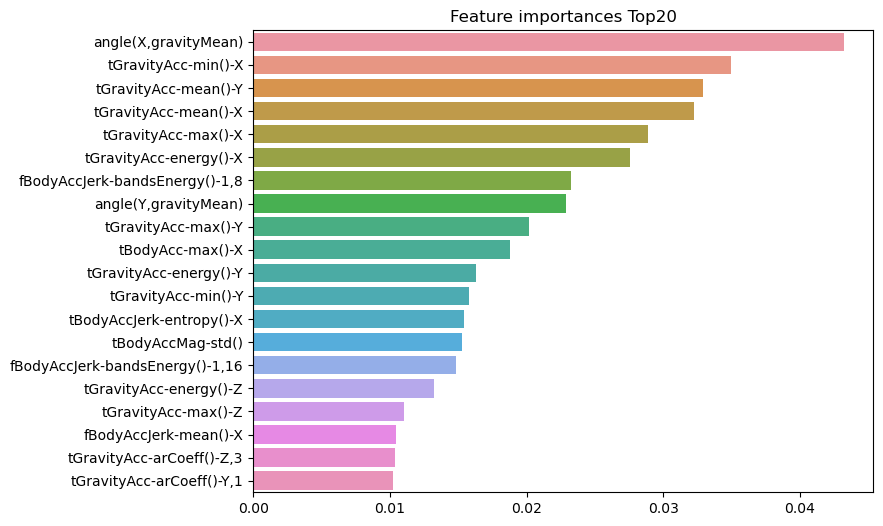

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8, 6))
plt.title('Feature importances Top20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

In [7]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

# GBM 수행 시간 측정을 위함. 시작 시간 설정.
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0, verbose=1)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, pred)

print('GBM 정확도 : {:.4f}'.format(gb_accuracy))
print('GBM 수행시간 : {:.4f}'.format(time.time() - start_time))

      Iter       Train Loss   Remaining Time 
         1           1.4065           17.36m
         2           1.1673           17.62m
         3           0.9906           17.62m
         4           0.8537           17.52m
         5           0.7423           17.39m
         6           0.6509           17.15m
         7           0.5750           17.00m
         8           0.5083           16.96m
         9           0.4557           16.76m
        10           0.4081           16.61m
        20           0.1660           14.96m


/root/anaconda3/envs/python_ML/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/root/anaconda3/envs/python_ML/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/root/anaconda3/envs/python_ML/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/root/anaconda3/envs/python_ML/lib/python3.8/site-packages/sklearn/model_selection

        30           0.0841           13.13m
        40           0.0515           11.22m
        50           0.0357            9.36m
        60           0.0260            7.47m
        70           0.0199            5.61m
        80           0.0158            3.74m
        90           0.0130            1.87m
       100           0.0105            0.00s
GBM 정확도 : 0.9019
GBM 수행시간 : 1123.1897


In [8]:
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, pred)

print('GBM 정확도 : {:.4f}'.format(gb_accuracy))
print('GBM 수행시간 : {:.4f}'.format(time.time() - start_time))

GBM 정확도 : 0.9019
GBM 수행시간 : 1123.3210


In [9]:
import xgboost

print(xgboost.__version__)

1.5.0


In [10]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings 
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
features = dataset.data
labels = dataset.target

cancer_df = pd.DataFrame(data=features, columns = dataset.feature_names)
cancer_df['target']=labels
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [11]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [12]:
# cancer_df에서 feature용 DataFrame과 Label용 Series 객체 추출
# 맨 마지막 칼럼이 Label임. Feature용 데이터 프레임은 cancer_df의 첫번째 칼럼에서 맨 마지막 두번째 칼럼 까지를 :-1 슬라이싱으로 추출
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label, test_size=0.2, random_state=156)

# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습용 10% 검증용데이터로 분할
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=156)

print(X_train.shape, X_test.shape)
print(X_tr.shape, X_val.shape)

(455, 30) (114, 30)
(409, 30) (46, 30)


In [13]:
# 학습, 검증, 테스트용 DMatrix 생성
dtr = xgb.DMatrix(data=X_tr, label=y_tr)
dval = xgb.DMatrix(data=X_val, label=y_val)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [14]:
params = {
    'max_depth': 3,
    'eta': 0.05,
    'objectibe': 'binary:logistic',
    'eval_metric': 'logloss'
}
num_rounds = 400

In [15]:
# 학습 데이터 셋은 'train' 또는 평가 데이터 셋은 'eval'로 명기합니다.
eval_list = [(dtr, 'train'), (dval, 'eval')] # 또는 [(dval, 'eval')]만 명기해도 무방.

# 하이퍼 파라미터와 earlystopping 파라미터를 train()합수의 파라미터로 전달
xgb_model = xgb.train(params=params, dtrain=dtr, num_boost_round=num_rounds, 
                      early_stopping_rounds=50, evals=eval_list)

[02:29:43] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "objectibe" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-logloss:0.64853	eval-logloss:0.65930
[1]	train-logloss:0.60826	eval-logloss:0.63160
[2]	train-logloss:0.57127	eval-logloss:0.60798
[3]	train-logloss:0.53723	eval-logloss:0.58486
[4]	train-logloss:0.50618	eval-logloss:0.56483
[5]	train-logloss:0.47729	eval-logloss:0.54714
[6]	train-logloss:0.45083	eval-logloss:0.52984
[7]	train-logloss:0.42513	eval-logloss:0.50945
[8]	train-logloss:0.40134	eval-logloss:0.49076
[9]	train-logloss:0.38012	eval-logloss:0.47865
[10]	train-logloss:0.35951	eval-logloss:0.46263
[11]	train-logloss:0.34034	eval-logloss:0.44788
[12]	train

In [16]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결괏값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10], 3))

# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정하여 list 객체인 preds에 저장
preds = [1 if x > 0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시 :', preds[:10])

predict() 수행 결괏값을 10개만 표시, 예측 확률 값으로 표시됨
[ 0.705  0.058  0.53   0.574  0.999  1.007  1.008  1.009  0.978 -0.004]
예측값 10개만 표시 : [1, 0, 1, 1, 1, 1, 1, 1, 1, 0]


In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix, \
precision_score, recall_score, f1_score, roc_auc_score
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # f1 score print
    print(f"정확도 : {accuracy:.4f}, 정밀도 : {precision:.4f}, 재현율 : {recall:.4f}, \
    F1 score : {f1:.4f}, AUC : {roc_auc:.4f}")

In [18]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 겨로갓값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10], 3))

# 예측확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정하여 list객체인 preds에 저장
pred = [1 if x > 0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시 :', preds[:10])

get_clf_eval(y_test, pred, pred_probs)

predict() 수행 겨로갓값을 10개만 표시, 예측 확률 값으로 표시됨
[ 0.705  0.058  0.53   0.574  0.999  1.007  1.008  1.009  0.978 -0.004]
예측값 10개만 표시 : [1, 0, 1, 1, 1, 1, 1, 1, 1, 0]
오차 행렬
[[34  3]
 [ 2 75]]
정확도 : 0.9561, 정밀도 : 0.9615, 재현율 : 0.9740,     F1 score : 0.9677, AUC : 0.9937


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

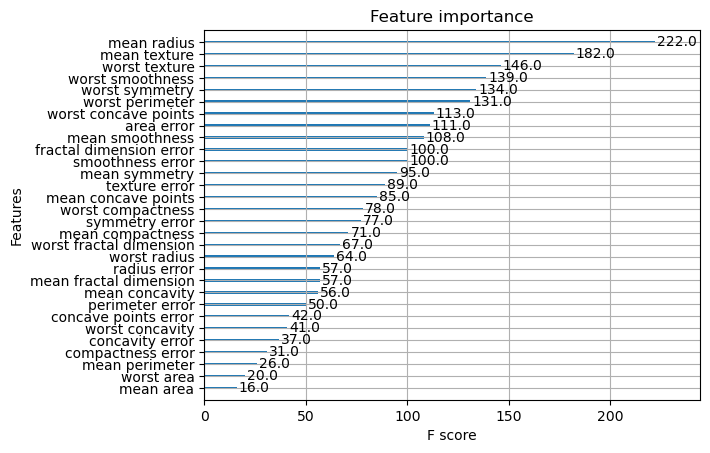

In [21]:
xgboost.plot_importance(xgb_model)

In [22]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier import
from xgboost import XGBClassifier

# warning 메시지를 없애기 위해 eval_metric 값을 XGBClassifier 생성 인자로 입력
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3, eval_metric='logloss')
xgb_wrapper.fit(X_train, y_train, verbose=True)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

In [23]:
get_clf_eval(y_test, w_preds, w_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도 : 0.9649, 정밀도 : 0.9620, 재현율 : 0.9870,     F1 score : 0.9744, AUC : 0.9954


In [24]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.5, max_depth=3)
evals = [(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=100, eval_metric='logloss', 
                eval_set=evals, verbose=True)
ws50_preds = xgb_wrapper.predict(X_test)
ws_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.35554	validation_1-logloss:0.45915
[1]	validation_0-logloss:0.21879	validation_1-logloss:0.35750
[2]	validation_0-logloss:0.14308	validation_1-logloss:0.30244
[3]	validation_0-logloss:0.10146	validation_1-logloss:0.27501
[4]	validation_0-logloss:0.07421	validation_1-logloss:0.26152
[5]	validation_0-logloss:0.05751	validation_1-logloss:0.26290
[6]	validation_0-logloss:0.04717	validation_1-logloss:0.27088
[7]	validation_0-logloss:0.03729	validation_1-logloss:0.27125
[8]	validation_0-logloss:0.03133	validation_1-logloss:0.29146
[9]	validation_0-logloss:0.02748	validation_1-logloss:0.29061
[10]	validation_0-logloss:0.02375	validation_1-logloss:0.29161
[11]	validation_0-logloss:0.02058	validation_1-logloss:0.29964
[12]	validation_0-logloss:0.01792	validation_1-logloss:0.27732
[13]	validation_0-logloss:0.01636	validation_1-logloss:0.27806
[14]	validation_0-logloss:0.01472	validation_1-logloss:0.27727
[15]	validation_0-logloss:0.01350	validation_1-logloss:0.26936
[1

In [25]:
get_clf_eval(y_test, ws50_preds, ws_pred_proba)

오차 행렬
[[34  3]
 [ 3 74]]
정확도 : 0.9474, 정밀도 : 0.9610, 재현율 : 0.9610,     F1 score : 0.9610, AUC : 0.9930


In [26]:
# Ealry stopping 옵션을 10으로 설정하고 재학습
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=10, eval_metric='logloss', 
                eval_set=evals, verbose=True)
ws50_preds = xgb_wrapper.predict(X_test)
ws_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.35554	validation_1-logloss:0.45915
[1]	validation_0-logloss:0.21879	validation_1-logloss:0.35750
[2]	validation_0-logloss:0.14308	validation_1-logloss:0.30244
[3]	validation_0-logloss:0.10146	validation_1-logloss:0.27501
[4]	validation_0-logloss:0.07421	validation_1-logloss:0.26152
[5]	validation_0-logloss:0.05751	validation_1-logloss:0.26290
[6]	validation_0-logloss:0.04717	validation_1-logloss:0.27088
[7]	validation_0-logloss:0.03729	validation_1-logloss:0.27125
[8]	validation_0-logloss:0.03133	validation_1-logloss:0.29146
[9]	validation_0-logloss:0.02748	validation_1-logloss:0.29061
[10]	validation_0-logloss:0.02375	validation_1-logloss:0.29161
[11]	validation_0-logloss:0.02058	validation_1-logloss:0.29964
[12]	validation_0-logloss:0.01792	validation_1-logloss:0.27732
[13]	validation_0-logloss:0.01636	validation_1-logloss:0.27806
[14]	validation_0-logloss:0.01472	validation_1-logloss:0.27727


In [27]:
get_clf_eval(y_test, ws50_preds, ws_pred_proba)

오차 행렬
[[34  3]
 [ 4 73]]
정확도 : 0.9386, 정밀도 : 0.9605, 재현율 : 0.9481,     F1 score : 0.9542, AUC : 0.9918


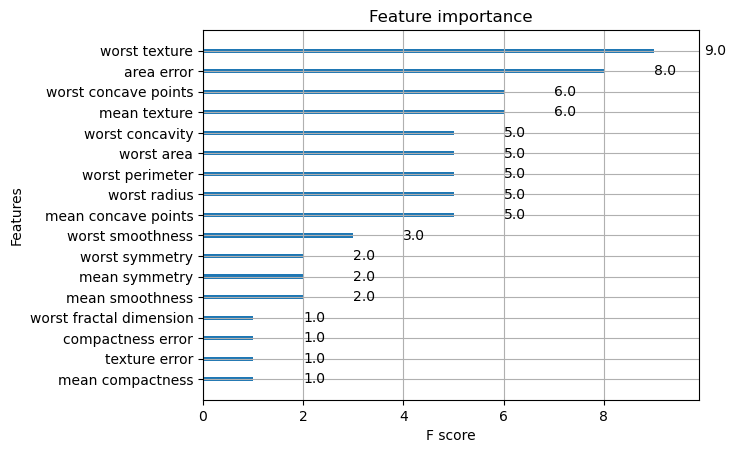

In [28]:
xgboost.plot_importance(xgb_wrapper);